<a id='h0'></a>
# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки:</b>

DateCrawled — дата скачивания анкеты из базы <br>
VehicleType — тип автомобильного кузова <br>
RegistrationYear — год регистрации автомобиля<br>
Gearbox — тип коробки передач <br>
Power — мощность (л. с.)<br>
Model — модель автомобиля<br>
Kilometer — пробег (км)<br>
RegistrationMonth — месяц регистрации автомобиля<br>
FuelType — тип топлива<br>
Brand — марка автомобиля<br>
Repaired — была машина в ремонте или нет<br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>

<b>Целевой признак:</b>

Price — цена (евро)<br>

<h1>Содержание (кликабельное):</h1>
    
<a href='#h0'>Название прокта</a><br>
<a href='#h1'>1. Подготовка данных</a><br>
&nbsp;&nbsp;&nbsp;<a href='#h11'>1.1 Вывод</a><br>
<a href='#h2'>2. Обучение моделей</a><br>
&nbsp;&nbsp;&nbsp;<a href='#h21'>2.1 Вывод</a><br>
<a href='#h3'>3. Анализ моделей</a><br>
&nbsp;&nbsp;&nbsp;<a href='#h31'>3.1 Вывод</a><br>
<a href='#h4'>4 Общий вывод</a><br>
<a href='#h5'>5 Чек-лист проверки</a><br>

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import cross_val_score
from time import time

pd.set_option('display.max_columns', None)

state = 55555

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install scikit-learn==1.1.3 

     |████████████████████████████████| 30.8 MB 49 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


<a id='h1'></a>
## Подготовка данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data2 = pd.read_csv('/datasets/autos.csv')

In [5]:
data2['DateCrawled'].max()

'2016-04-07 14:36:58'

In [6]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
data.shape

(354369, 16)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [10]:
data.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')>

Переименнуем столбцы

In [11]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [12]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
data.duplicated().sum()

4

In [14]:
data['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

Удалим столбцы которые не будут использоватся в анализе, т.е те столбцы в которых хранится информация о действиях пользователя

In [15]:
data.drop(['date_crawled', 'date_created', 
         'number_of_pictures', 'postal_code', 'last_seen','registration_month'], axis=1, inplace=True)

Проверим на дубликаты

In [16]:
data.duplicated().sum()

45040

появилось большое количество дубликатов пока не будем их трогать

Посмотрим как заполнены данные.

In [17]:
data.isnull().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Рассмотрим подробнее

In [18]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Заменим пропуски значением other

In [20]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [21]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [22]:
data['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Заполним пропуски

In [23]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [24]:
data.loc[(data['model'] == 'rangerover')]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
27949,1050,small,1998,manual,103,rangerover,150000,petrol,rover,NaN
117409,16900,other,2007,auto,190,rangerover,150000,gasoline,rover,no
169654,2500,suv,1996,manual,0,rangerover,150000,gasoline,rover,no
279463,3300,other,2017,manual,135,rangerover,150000,gasoline,rover,no


In [25]:
data.loc[(data['model'] == 'rangerover'), 
       'model'] = 'range_rover'

In [26]:
data['model'] = data['model'].fillna('other')

In [27]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              19833
power                    0
model                    0
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Будем считать, что машина машина не попадала в аварию если это поле не указанно

In [28]:
data['repaired'] = data['repaired'].fillna('no')

In [29]:
data['repaired'].value_counts()

no     318315
yes     36054
Name: repaired, dtype: int64

In [30]:
data.isnull().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              19833
power                    0
model                    0
kilometer                0
fuel_type            32895
brand                    0
repaired                 0
dtype: int64

In [31]:
data.describe(include='all')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
count,354369.000000,354369,354369.000000,334536,354369.000000,354369,354369.000000,321474,354369,354369
unique,NaN,8,NaN,2,NaN,249,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,other,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,44126,NaN,216352,77013,318315
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


In [32]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       354369 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              354369 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Удалим выбросы

In [34]:
def plot(df, x, x_label, y_label, title, bins):
    sum_val[metric].plot(
            title = 'Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках для {}'.format(metric),
            kind='hist', 
            bins=100, 
            grid=True, 
            figsize=(15, 6),
            alpha=0.5,
            label=label,
        ).set(xlabel='Сумма долей компонентов', ylabel = 'Частота')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

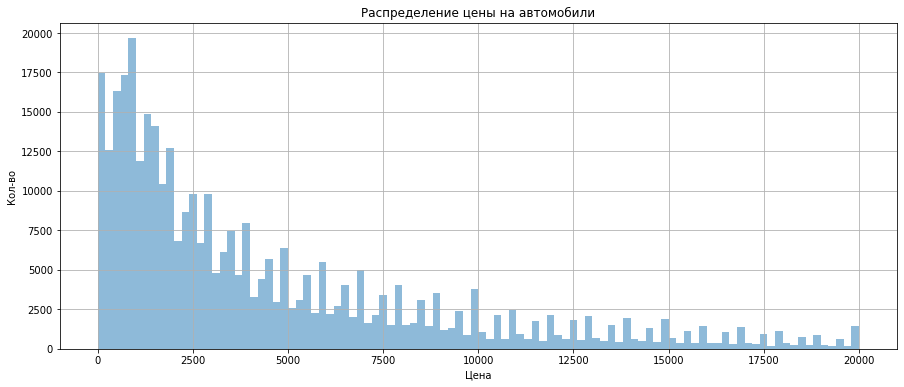

In [35]:
data['price'].plot(
            title = 'Распределение цены на автомобили',
            kind='hist', 
            bins=100, 
            grid=True, 
            figsize=(15, 6),
            alpha=0.5,
        ).set(xlabel='Цена', ylabel = 'Кол-во')
plt.show()
    

<AxesSubplot:>

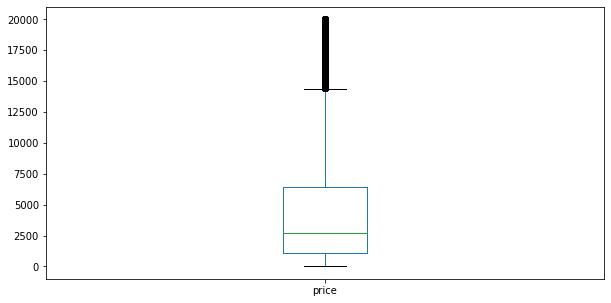

In [36]:
data['price'].plot(kind='box', figsize=(10, 5))

Выделим квантили 5% и 95%.

In [37]:
data['price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

In [38]:
data.loc[data['price'] < 200 ].shape[0]

17462

In [39]:
data.loc[data['price']> 19000]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
484,19900,bus,2009,manual,150,viano,90000,gasoline,mercedes_benz,no
1360,19850,sedan,2013,auto,150,golf,60000,gasoline,volkswagen,no
1515,20000,sedan,2010,auto,239,a6,150000,gasoline,audi,no
1586,20000,sedan,2014,auto,184,leon,40000,gasoline,seat,no
...,...,...,...,...,...,...,...,...,...,...
353193,19500,bus,1970,auto,69,transporter,30000,petrol,volkswagen,no
353590,19950,wagon,2009,manual,265,other,125000,petrol,audi,no
354045,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
354178,19990,small,2014,auto,185,a1,10000,petrol,audi,no


Удалим только машины у которых цена меньше 200. По графику видно большое количество выбросов после 7500.

In [40]:
data = data.drop(data.query('price <= 200').index).reset_index(drop=True)

In [41]:
data.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              15274
power                    0
model                    0
kilometer                0
fuel_type            26761
brand                    0
repaired                 0
dtype: int64

In [42]:
data.shape[0]

334921

In [43]:
data['vehicle_type'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

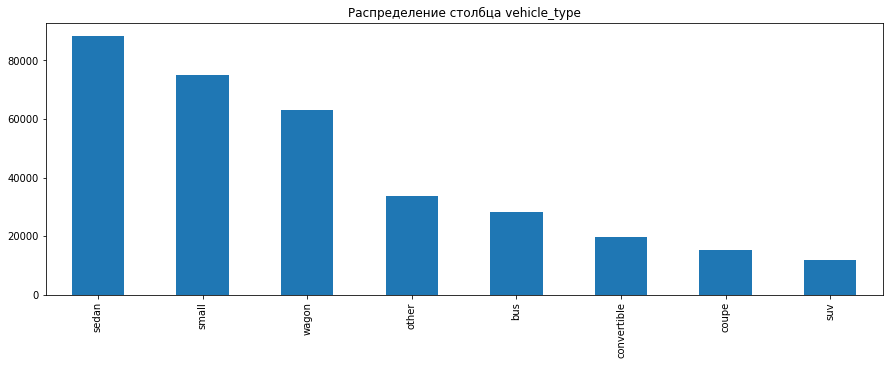

In [44]:
plt.figure(figsize=(15,5))
data['vehicle_type'].value_counts().plot.bar()
plt.title(f'Распределение столбца vehicle_type')
plt.show()

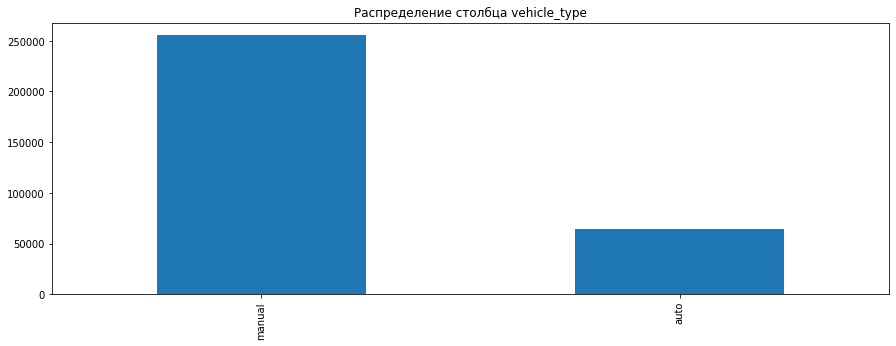

In [45]:
plt.figure(figsize=(15,5))
data['gearbox'].value_counts().plot.bar()
plt.title(f'Распределение столбца vehicle_type')
plt.show()

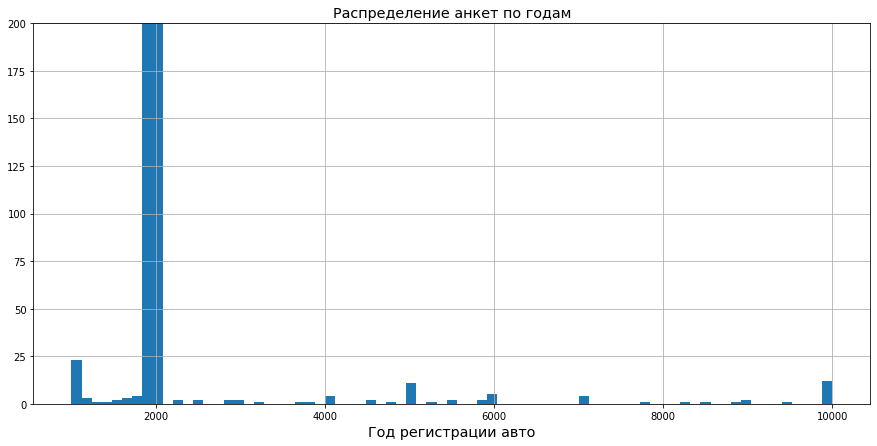

In [46]:
plt.figure(figsize=(15,7))
plt.ylim(0,200)
data['registration_year'].hist(bins=75,)
plt.title('Распределение анкет по годам', fontsize='x-large')
plt.xlabel('Год регистрации авто', fontsize='x-large')
plt.show()

<AxesSubplot:>

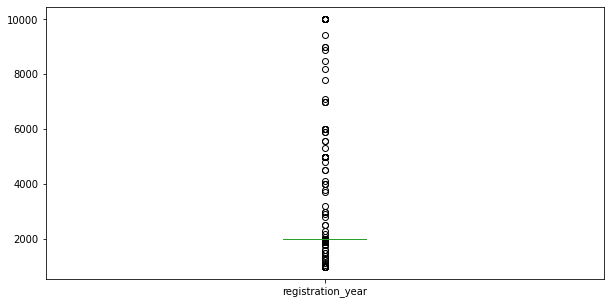

In [47]:
data['registration_year'].plot(kind='box', figsize=(10, 5))

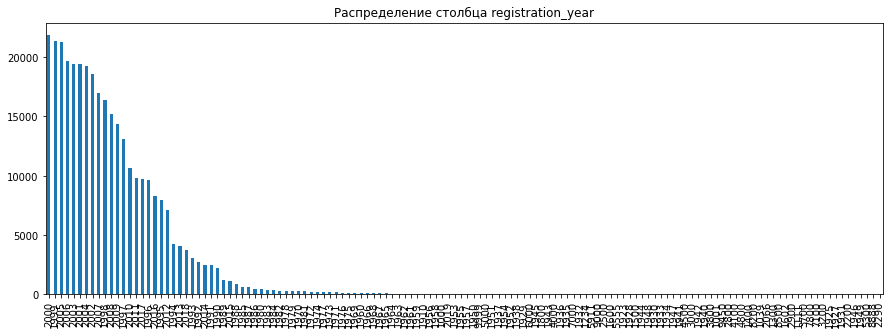

In [48]:
plt.figure(figsize=(15,5))
data['registration_year'].value_counts().plot.bar()
plt.title(f'Распределение столбца registration_year')
plt.show()


In [49]:
data['registration_year'].max()

9999

уберем все года регистрации больше текушего года.

In [50]:
data = data.drop(data.query('registration_year > 2023').index).reset_index(drop=True)

In [51]:
data['registration_year'].quantile([.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: registration_year, dtype: float64

In [52]:
data['registration_year']

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
334853    2000
334854    2005
334855    2000
334856    1996
334857    2002
Name: registration_year, Length: 334858, dtype: int64

Ну и так же уберем авто год регистрации которых меньше 1990 г.

In [53]:
data2['DateCrawled'].max()

'2016-04-07 14:36:58'

In [54]:
data2['RegistrationYear'].max()

9999

тогда:

In [55]:
data2[['RegistrationMonth','RegistrationYear']]

,RegistrationMonth,RegistrationYear
0,0,1993
1,5,2011
2,8,2004
3,6,2001
4,7,2008
...,...,...
354364,7,2005
354365,1,2005
354366,3,2000
354367,3,1996


In [56]:
data2['RegistrationMonth'].min() 

0

In [57]:
data2['RegistrationMonth'].max()

12

In [58]:
data2['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

In [59]:
data2['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [60]:
data['RegistrationMonth'] = data2['RegistrationMonth'] 

In [61]:
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,RegistrationMonth
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,no,0
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no,8
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,6
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,7
...,...,...,...,...,...,...,...,...,...,...,...
334853,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,10
334854,2200,other,2005,NaN,0,other,20000,NaN,sonstige_autos,no,3
334855,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,7
334856,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,7


Удали строки превышаюшие максимальную дату выгрузи анкеты,

In [62]:
data = data.drop(data.query('registration_year <= 1990').index).reset_index(drop=True)

In [64]:
data = data.drop(data.query('registration_year > 2017').index).reset_index(drop=True)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320244 entries, 0 to 320243
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              320244 non-null  int64 
 1   vehicle_type       320244 non-null  object
 2   registration_year  320244 non-null  int64 
 3   gearbox            306754 non-null  object
 4   power              320244 non-null  int64 
 5   model              320244 non-null  object
 6   kilometer          320244 non-null  int64 
 7   fuel_type          296607 non-null  object
 8   brand              320244 non-null  object
 9   repaired           320244 non-null  object
 10  RegistrationMonth  320244 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.9+ MB


In [66]:
data.drop(['RegistrationMonth'], axis=1, inplace=True)

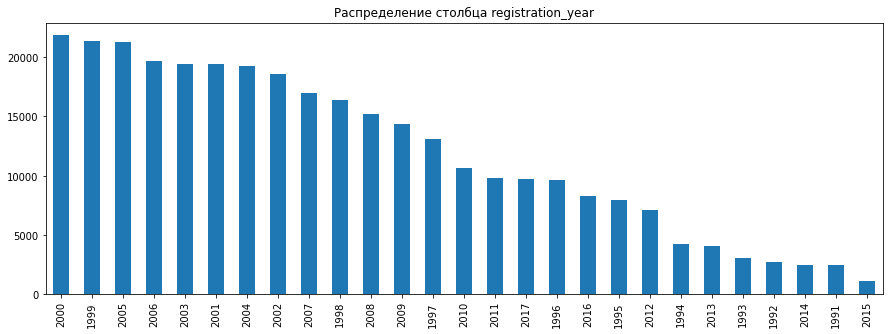

In [67]:
plt.figure(figsize=(15,5))
data['registration_year'].value_counts().plot.bar()
plt.title(f'Распределение столбца registration_year')
plt.show()

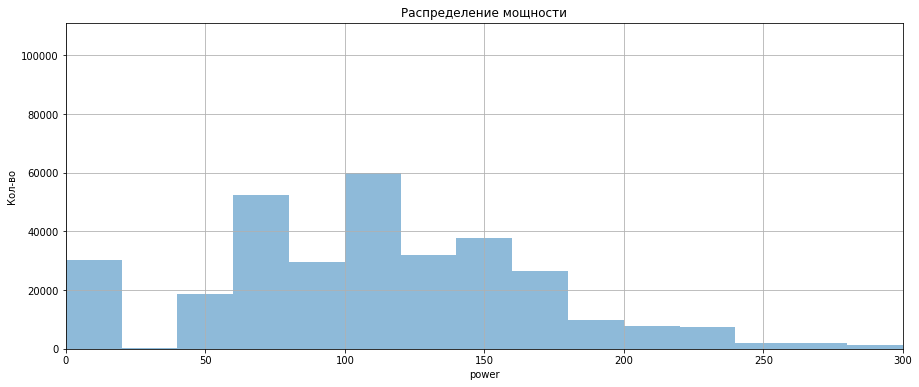

In [68]:
data['power'].plot(
            title = 'Распределение мощности',
            kind='hist', 
            bins=1000, 
            grid=True, 
            figsize=(15, 6),
            alpha=0.5,
        ).set(xlabel='power', ylabel = 'Кол-во')
plt.xlim(0,300)
plt.ylim(0,111111)
plt.show()

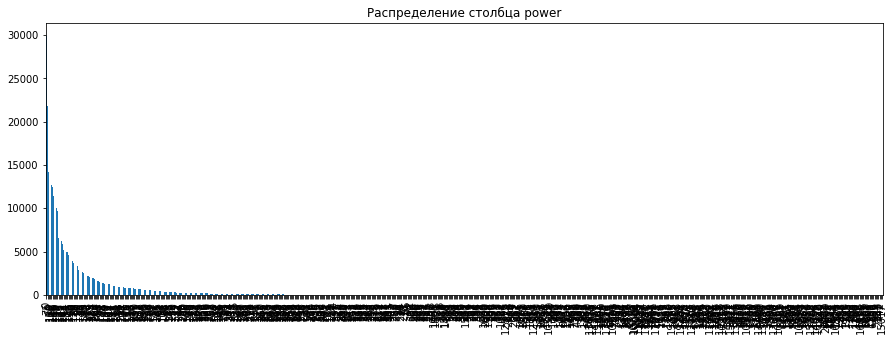

In [69]:
plt.figure(figsize=(15,5))
data['power'].value_counts().plot.bar()
plt.title(f'Распределение столбца power')
plt.show()

<AxesSubplot:>

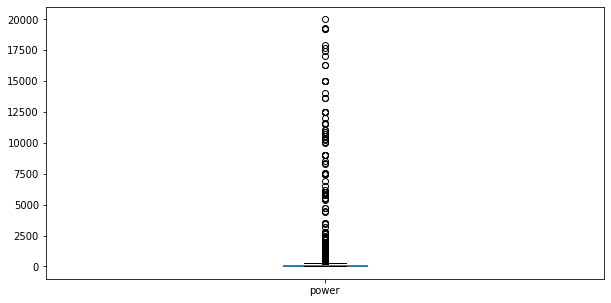

In [70]:
data['power'].plot(kind='box', figsize=(10, 5))

<AxesSubplot:>

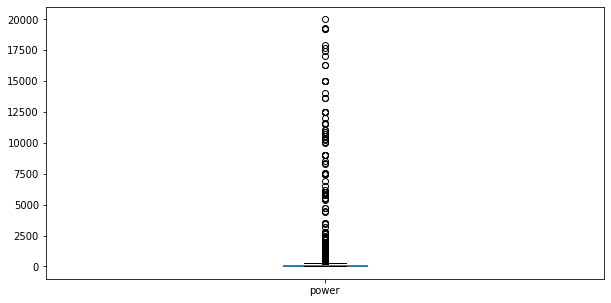

In [71]:
data['power'].plot(kind='box', figsize=(10, 5))

kilometer 

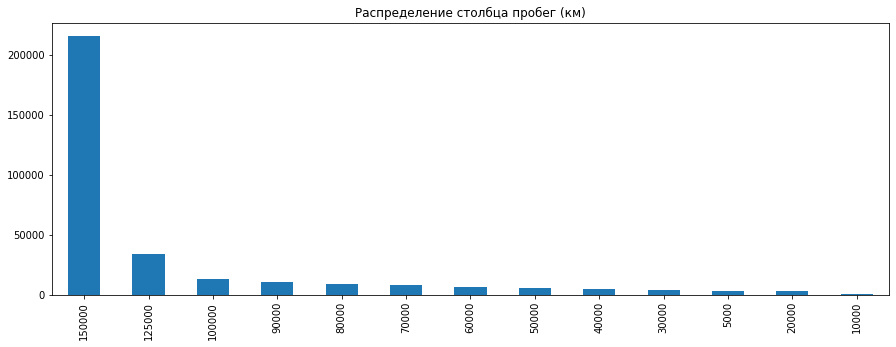

In [72]:
plt.figure(figsize=(15,5))
data['kilometer'].value_counts().plot.bar()
plt.title(f'Распределение столбца пробег (км)')
plt.show()

<AxesSubplot:>

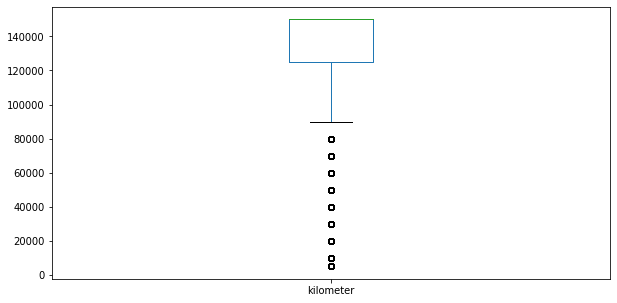

In [73]:
data['kilometer'].plot(kind='box', figsize=(10, 5))

In [74]:
data['kilometer'].quantile([.05, 0.95])

0.05     40000.0
0.95    150000.0
Name: kilometer, dtype: float64

Машины могут быть с новыми двигателями или почти новые поэтому минимальный пробег трогать не будем

<AxesSubplot:>

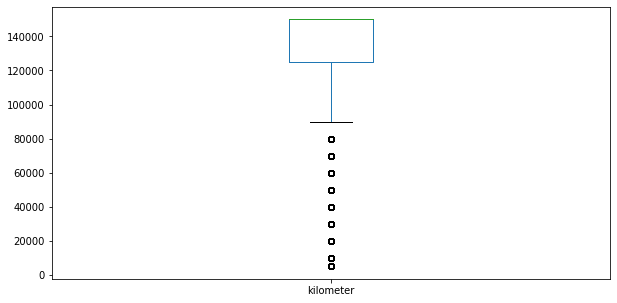

In [75]:
data['kilometer'].plot(kind='box', figsize=(10, 5))

In [76]:
data.query('kilometer > 140000')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,999,small,1998,manual,101,golf,150000,NaN,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
320237,5250,other,2016,auto,150,159,150000,NaN,alfa_romeo,no
320238,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
320239,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
320242,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


У большинства авто пробег 150000 км

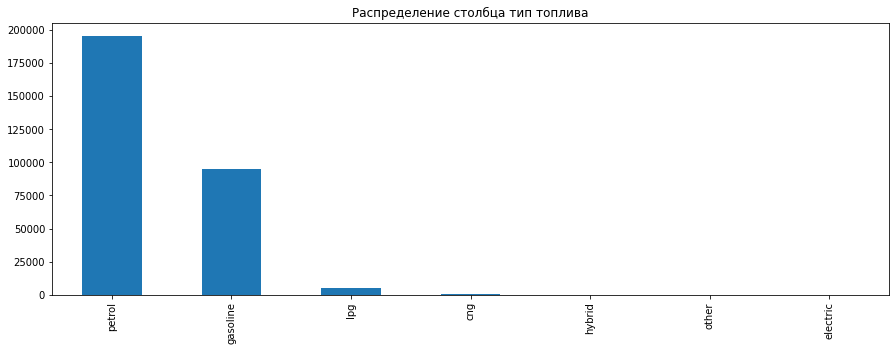

In [77]:
plt.figure(figsize=(15,5))
data['fuel_type'].value_counts().plot.bar()
plt.title(f'Распределение столбца тип топлива')
plt.show()

In [78]:
data['fuel_type'].value_counts()

petrol      195476
gasoline     95209
lpg           4993
cng            535
hybrid         224
other           87
electric        83
Name: fuel_type, dtype: int64

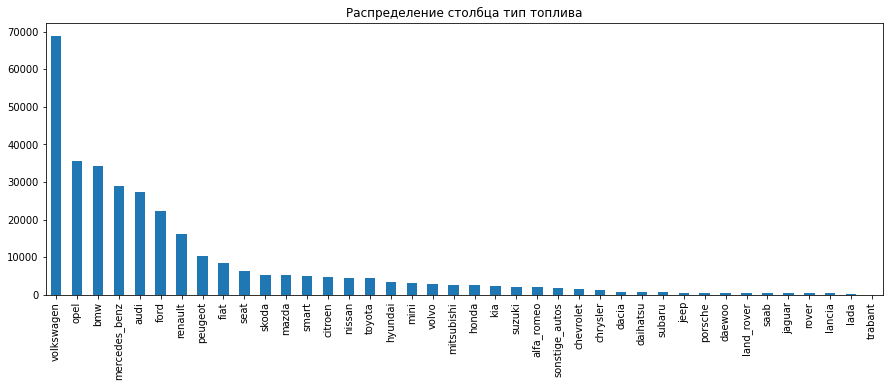

In [79]:
plt.figure(figsize=(15,5))
data['brand'].value_counts().plot.bar()
plt.title(f'Распределение столбца тип топлива')
plt.show()

In [80]:
data['brand'].value_counts()

volkswagen        68805
opel              35705
bmw               34212
mercedes_benz     28988
audi              27456
ford              22425
renault           16191
peugeot           10355
fiat               8482
seat               6420
skoda              5321
mazda              5210
smart              5085
citroen            4669
nissan             4525
toyota             4397
hyundai            3447
mini               3082
volvo              2927
mitsubishi         2754
honda              2567
kia                2355
suzuki             2073
alfa_romeo         2056
sonstige_autos     1730
chevrolet          1467
chrysler           1281
dacia               875
daihatsu            691
subaru              681
jeep                584
porsche             524
daewoo              496
land_rover          484
saab                476
jaguar              437
rover               421
lancia              392
lada                169
trabant              29
Name: brand, dtype: int64

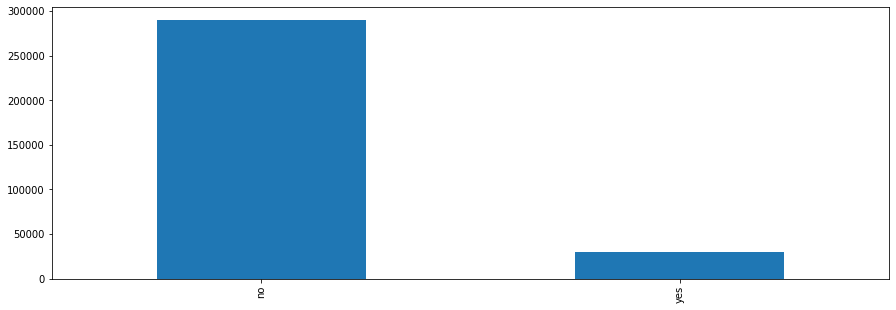

In [81]:
plt.figure(figsize=(15,5))
data['repaired'].value_counts().plot.bar()
plt.show()

In [82]:
data.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox              13490
power                    0
model                    0
kilometer                0
fuel_type            23637
brand                    0
repaired                 0
dtype: int64

In [83]:
data['gearbox'] = data['gearbox'].fillna('other') 

In [84]:
data['fuel_type'] = data['fuel_type'].fillna('FT') 

In [85]:
data.duplicated().sum()

48348

In [86]:
data.drop_duplicates(inplace=True)

In [87]:
data.duplicated().sum()

0

Дубликаты удалены

Построим корреляцию параметров:

Наблюдается довольно корреляция между стоимостью автомобиля и годом регистрации, а также его мощностью и годом. регистрации

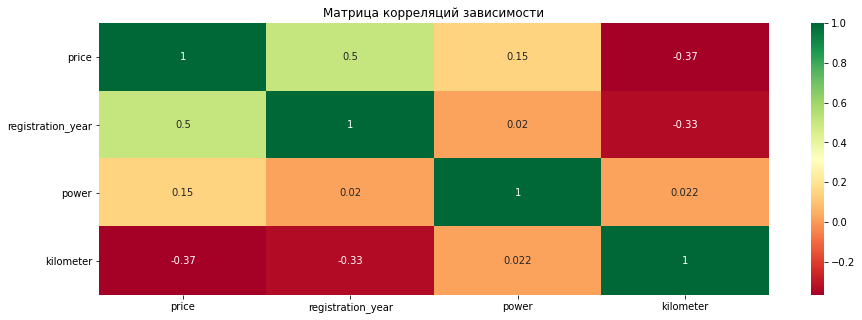

In [88]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости')
sns.heatmap(data.corr(), annot = True,cmap='RdYlGn')
plt.show()

<a id='h11'></a>
### Вывод: 
Ознакомились с данными <br>
Удалены аномальные и пропущенные значения.<br>
Отобраны небходимые столбцы для обучения модели.<br>
Заполнены пропуски в столбцах и удалены некорректные значения.<br>
Наблюдается довольно корреляция между стоимостью автомобиля и годом регистрации, а также его мощностью и годом. регистрации.<br>

<a id='h2'></a>
## Обучение моделей

Подготовка моделей

Разделим данные на обучающую и тестовую выборки

In [89]:
features = data.drop(['price'], axis=1)
target = data['price']

features_train, features_valid, target_train, target_valid = (train_test_split(features, target, test_size=0.4,random_state=state))

features_test, features_valid, target_test, target_valid  = train_test_split(features_valid, target_valid, test_size=0.5,  random_state=state) 

In [90]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(163137, 9)
(54380, 9)
(54379, 9)
(163137,)
(54380,)
(54379,)


In [91]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()
signs = cat_features
print(cat_features)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


In [92]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
147522,small,2001,manual,75,twingo,150000,FT,renault,no
308332,other,2017,manual,100,meriva,150000,petrol,opel,no
204664,sedan,1998,manual,215,passat,150000,petrol,volkswagen,no
71650,sedan,2000,auto,101,golf,150000,petrol,volkswagen,no
68506,sedan,1997,manual,170,other,150000,FT,bmw,no


In [93]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['registration_year', 'power', 'kilometer']

In [94]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

/tmp/ipykernel_48/2393655571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[num_features] = scaler.transform(features_train[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Для методов, которым нужны численные признаки проведем кодирование

In [95]:
features.select_dtypes('object').columns

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object')

In [96]:
onehotencoder = OneHotEncoder(drop='first', sparse=False).fit(features[cat_features])
feature_names = onehotencoder.get_feature_names(cat_features)

features_train_ohe = pd.concat([features_train[num_features],  
                                pd.DataFrame(onehotencoder.transform(features_train[cat_features]),
                                             columns=feature_names, 
                                             index=features_train.index)], 
                               axis=1)

In [97]:
features_valid_ohe = pd.concat([features_valid[num_features],  
                                pd.DataFrame(onehotencoder.transform(features_valid[cat_features]),
                                             columns=feature_names, 
                                             index=features_valid.index)], 
                               axis=1)

features_test_ohe = pd.concat([features_valid[num_features],  
                                pd.DataFrame(onehotencoder.transform(features_test[cat_features]),
                                             columns=feature_names, 
                                             index=features_test.index)], 
                               axis=1)

Для моделей, основанных на деревьях решений, будем использовать порядковое кодирование (OrdinalEncoder)

In [98]:
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

In [99]:
ordinalencoder = OrdinalEncoder(dtype=int).fit(features[cat_features])

In [100]:
features_train_oe[cat_features] = ordinalencoder.transform(features_train[cat_features])
features_valid_oe[cat_features] = ordinalencoder.transform(features_valid[cat_features])
features_test_oe[cat_features] = ordinalencoder.transform(features_test[cat_features])

Линейная регрессия

In [101]:
lr = LinearRegression()

start = time()

lr.fit(features_train_ohe, target_train)
time_to_fit_lr = time() - start
print('Время обучения %.2f секунд' %time_to_fit_lr)

start = time()
predicted = lr.predict(features_valid_ohe)
time_to_predict_lr = time() - start
print('Модель предсказывает за %.2f секунд' %time_to_predict_lr)

rmse_lr = mean_squared_error(target_valid, predicted, squared=False)
print('RMSE =', rmse_lr)

Время обучения 19.12 секунд
Модель предсказывает за 0.40 секунд
RMSE = 2615.4684936322183


Древо решений

In [102]:
param = {"max_depth": list(range(4,30,2)),
                 "min_samples_leaf": list(range(10, 80,10)),
                 "max_leaf_nodes": list(range(10, 80,10)),
                 }


Подбор параметров

In [103]:
DTS = DecisionTreeRegressor() 
model_dts = RandomizedSearchCV(estimator=DTS,
                                      param_distributions= param,  scoring='neg_mean_absolute_error', random_state=state, n_jobs=-1)


model_dts.fit(features_train_oe, target_train)

model_dts.predict(features_valid_oe)
    
print('Лучшие параметры:', model_dts.best_params_)

Лучшие параметры: {'min_samples_leaf': 50, 'max_leaf_nodes': 70, 'max_depth': 28}


In [104]:
model_dts = DecisionTreeRegressor(min_samples_split=50, min_samples_leaf = 50, max_leaf_nodes = 87, max_depth = 28, random_state=state)

start = time()
model_dts.fit(features_train_oe, target_train)
time_to_fit_dts = time() - start
print('Время обучения %.2f секунд' %time_to_fit_dts)

start = time()
predicted = model_dts.predict(features_valid_oe)
time_to_predict_dts = time() - start
print('Модель предсказывает за %.2f секунд' %time_to_predict_dts)

rmse_dts = mean_squared_error(target_valid, predicted, squared=False)
print('RMSE =', rmse_dts)

Время обучения 0.23 секунд
Модель предсказывает за 0.01 секунд
RMSE = 2203.508705061181


In [105]:
cat_columns = ['vehicle_type', 'gearbox', 'vehicle_type', 'model', 'fuel_type', 'brand', 'repaired']

CatBoost

In [106]:
model_cat = CatBoostRegressor(cat_features=cat_columns)

start = time()
model_cat.fit(features_train, target_train)
time_to_fit_cat = time() - start
print('Время обучения %.2f секунд' %time_to_fit_cat)

start = time()
predicted = model_cat.predict(features_valid)
time_to_predict_cat = time() - start
print('Модель предсказывает за %.2f секунд' %time_to_predict_cat)

rmse_cat = mean_squared_error(target_valid, predicted, squared=False)
print('RMSE =', rmse_cat)

Learning rate set to 0.091572
0:	learn: 4313.4855935	total: 246ms	remaining: 4m 6s
1:	learn: 4065.5322620	total: 447ms	remaining: 3m 43s
2:	learn: 3841.5378955	total: 653ms	remaining: 3m 36s
3:	learn: 3645.6990537	total: 804ms	remaining: 3m 20s
4:	learn: 3465.0894905	total: 961ms	remaining: 3m 11s
5:	learn: 3307.5630489	total: 1.14s	remaining: 3m 8s
6:	learn: 3166.3785385	total: 1.35s	remaining: 3m 11s
7:	learn: 3034.5478194	total: 1.52s	remaining: 3m 8s
8:	learn: 2915.9124814	total: 1.7s	remaining: 3m 6s
9:	learn: 2817.0311783	total: 1.86s	remaining: 3m 4s
10:	learn: 2725.4541421	total: 2.02s	remaining: 3m 1s
11:	learn: 2646.7273396	total: 2.18s	remaining: 2m 59s
12:	learn: 2572.4811590	total: 2.37s	remaining: 2m 59s
13:	learn: 2501.1962127	total: 2.54s	remaining: 2m 59s
14:	learn: 2440.0231220	total: 2.7s	remaining: 2m 57s
15:	learn: 2383.8235333	total: 2.84s	remaining: 2m 54s
16:	learn: 2332.6144903	total: 2.98s	remaining: 2m 52s
17:	learn: 2289.2392587	total: 3.14s	remaining: 2m 51

In [107]:
cat_feature_names = features_train.select_dtypes("object").columns
features_train[cat_feature_names] = features_train[cat_feature_names].astype("category")

cat_feature_names2 = features_valid.select_dtypes("object").columns
features_valid[cat_feature_names2] = features_valid[cat_feature_names2].astype("category")

cat_feature_names3 = features_test.select_dtypes("object").columns
features_test[cat_feature_names3] = features_test[cat_feature_names3].astype("category")

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [108]:
model_LGBM = lgb.LGBMRegressor()

start = time()
fit = model_LGBM.fit(features_train, target_train)
time_to_fit_LGBM = time() - start
print('Время обучения %.2f секунд' %time_to_fit_LGBM)

start = time()
predicted = model_LGBM.predict(features_valid)
time_to_predict_LGBM = time() - start
print('Модель предсказывает за %.2f секунд' %time_to_predict_LGBM)

rmse_LGBM = mean_squared_error(target_valid, predicted , squared=False)
print('RMSE =', rmse_LGBM)

Время обучения 4.24 секунд
Модель предсказывает за 0.61 секунд
RMSE = 1618.7255936974088


In [109]:
index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']

result_data = [
    {'Время обучения сек.' :time_to_fit_lr, 'Модель предсказывает за сек': time_to_predict_lr, 'RMSE':rmse_lr},
    {'Время обучения сек.' :time_to_fit_dts, 'Модель предсказывает за сек': time_to_predict_dts, 'RMSE':rmse_dts},
    {'Время обучения сек.' :time_to_fit_cat, 'Модель предсказывает за сек': time_to_predict_cat, 'RMSE':rmse_cat},
    {'Время обучения сек.' :time_to_fit_LGBM, 'Модель предсказывает за сек': time_to_predict_LGBM, 'RMSE': rmse_LGBM},
]

result_table = pd.DataFrame(result_data, index=index)
result_table

,Время обучения сек.,Модель предсказывает за сек,RMSE
LinearRegression,19.115554,0.396247,2615.468494
DecisionTreeRegressor,0.232378,0.006207,2203.508705
CatBoostRegressor,144.544464,0.417346,1597.138948
LGBMRegressor,4.236874,0.609512,1618.725594


<a id='h21'></a>
### Вывод
Были изучены 4 модели, время их выполнения и результат rmse

Самая быстро обучаемае модель DecisionTreeRegressor, модель с наибыстрейшими показаниями DecisionTreeRegressor 0.005617 сек.
Возьмем модели LGBMRegressor для финального теста.

<a id='h3'></a>
## Анализ моделей

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

По результатам сравнения моделей у DecisionTreeRegressor наилучшая скорость предсказания, и время обучения, и третье по значению RMSE равное '2203'
Лучшая модель по результам RMSE CatBoostRegressor '1597', но у нее самое долгое время обучния, 	
LGBMRegressor имеет почти такой же результат RMSE, равный 1618, но время обучения и время предсказания значительно лучше, чем у CatBoostRegressor, по этим показателя эта модельна втором месте среди моделей.


Критерии, которые важны заказчику:<br>
качество предсказания;<br>
время обучения модели;<br>
время предсказания модели.<br>

Так как заказчику в первую очередь важно качество предсказания, то я выберу модель у которой RMSE наименьшая.
так время пресказания у моделей меньше секунды,а Время обучения сек. не сильная разница между ними, потому будем тестировать эту модель

Проверим модель на тестовой выборке:

In [110]:
model_LGBM = lgb.LGBMRegressor()

start = time()
fit = model_LGBM.fit(features_train, target_train)
time_to_fit_LGBM = time() - start
print('Время обучения %.2f секунд' %time_to_fit_LGBM)

start = time()
predicted = model_LGBM.predict(features_test)
time_to_predict_LGBM = time() - start
print('Модель предсказывает за %.2f секунд' %time_to_predict_LGBM)

rmse_LGBM = mean_squared_error(target_test, predicted , squared=False)
print('RMSE =', rmse_LGBM)

Время обучения 4.47 секунд
Модель предсказывает за 0.60 секунд
RMSE = 1626.297764771382


<a id='h31'></a>
### Вывод

Мы достигли требуемого значения RMSE на тестовой выборке для нашей выбраной модели LGBMRegressor меньше 2500.

<a id='h4'></a>
## Итоговый вывод

В ходе работы было выполнено:<br>
1.Загружены данные и проведена предобработка.<br>
2.Были изучены 4 регрессионных модели, время их выполнения и реузльтат rmse моделей, время их выполнения и результат rmse <br>
3.Выполнено сравнение моделей <br>
4.Была выбрана лучшая модель LGBMRegressor

LGBMRegressor поможет сделать точные предсказания и довольно быстрые предсказания